# Secure Predictive Modeling for Care Navigation & Operations  

## Context

**Simulated Health Tech Case Study**

This notebook presents a simulated, end-to-end data science case study inspired by the operational challenges faced by modern mental health platforms.

The objective is to demonstrate how predictive modeling, bias-aware feature engineering, and privacy-preserving techniques can support:
- Equitable care navigation
- Revenue cycle and resource planning
- HIPAA-aligned data practices

All data used in this notebook is anonymized and used solely for methodological demonstration.


## Executive Summary

This project demonstrates how machine learning can be applied responsibly in health tech environments where trust, privacy, and interpretability are critical.

Key outcomes:
- Feature scaling was shown to be essential for unbiased patient stratification.
- Machine learning significantly outperformed baseline heuristics in predicting benefit utilization.
- A linear algebra–based data obfuscation technique preserved model accuracy while protecting sensitive data.

Together, these results show that privacy, performance, and operational impact can coexist in healthcare analytics.


## Imports and data loading


In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from IPython.display import display
import random

In [2]:
raw_df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/insurance_us.csv')

In [3]:
# Loading the dataset and standardizing column nomenclature to align with engineering best practices.
raw_df.columns = (
    raw_df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
)

clean_df = raw_df.rename(columns={
    'salary': 'income'
})

In [4]:
clean_df.sample(5)

,gender,age,income,family_members,insurance_benefits
3958,1,32.0,48200.0,3,0
4522,1,22.0,52500.0,2,0
4421,1,20.0,47300.0,1,0
3682,0,28.0,44700.0,3,0
4657,1,23.0,43400.0,1,0


In [5]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# Optimizing memory usage by converting float types to integers where appropriate.
clean_df['age'] = clean_df['age'].astype('int')
clean_df['income'] = clean_df['income'].astype('int')

In [7]:
# Conducting initial statistical profiling to detect outliers in patient demographics (Age, Family Size) that could skew predictive models.
clean_df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Exploratory Data Analysis (EDA)

We utilize PairPlots to visualize multivariate relationships between patient demographics and service utilization. Unlike simple linear correlations, visual inspection allows us to identify non-linear clusters of patients who may require distinct care strategies.

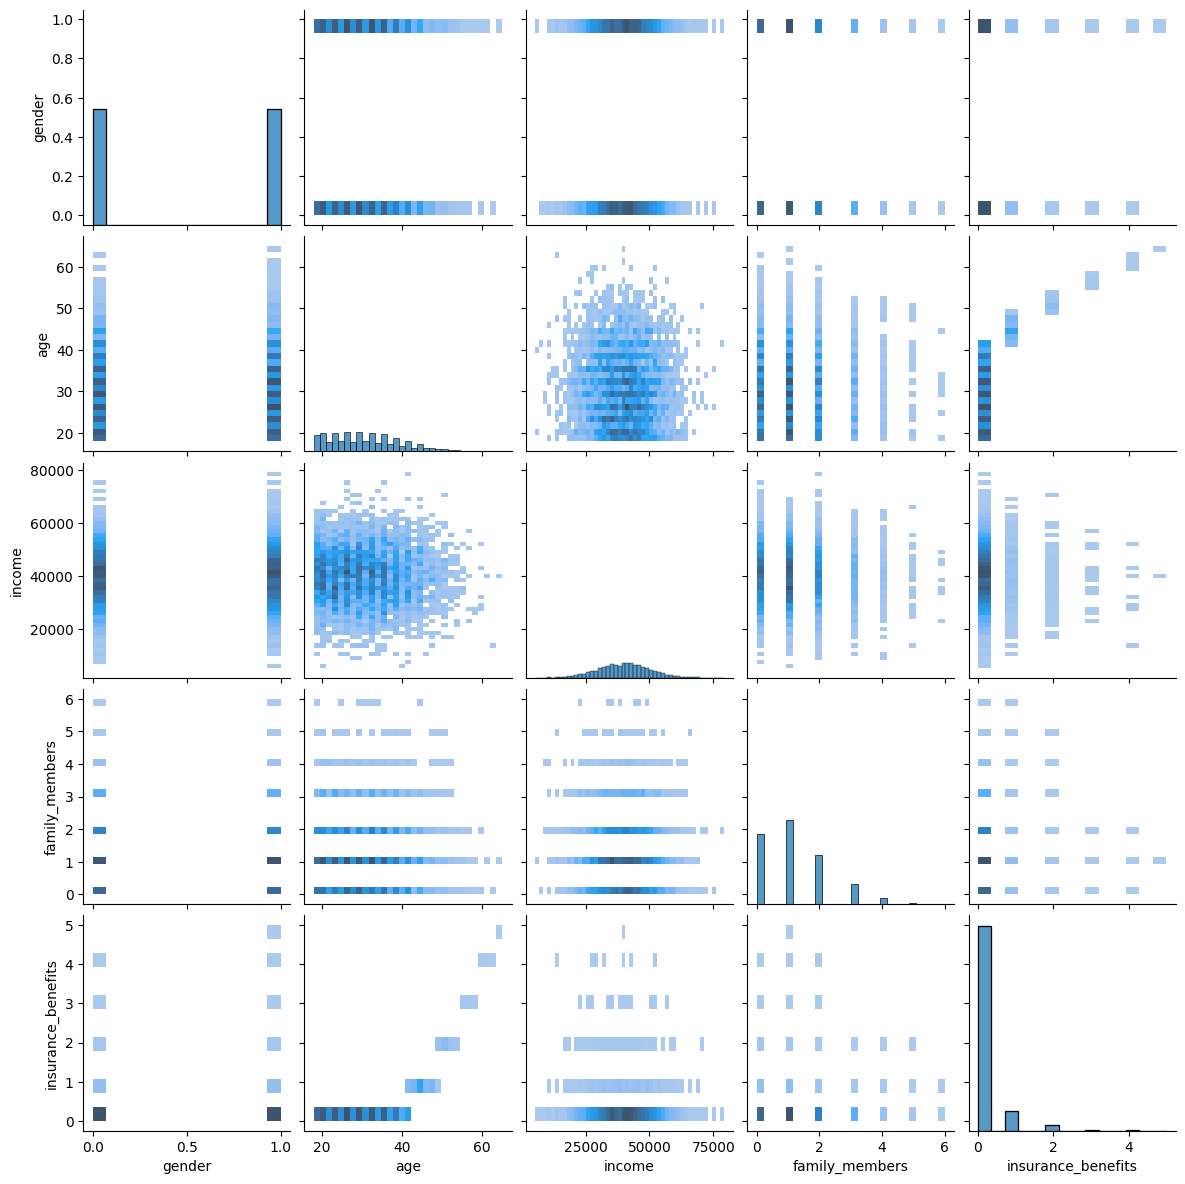

In [8]:
g = sns.pairplot(clean_df, kind='hist')
g.fig.set_size_inches(12, 12)

The absence of clear linear separation reinforces the need for distance-based and non-linear methods when modeling patient similarity.

# Task 1: Patient Stratification (Care Navigation)

To deliver personalized mental health support, we must identify patient cohorts. By finding the 'Nearest Neighbors' in our data, we can match a new patient to historical cases with similar profiles to recommend effective treatment plans.

We evaluate how feature scaling impacts patient similarity modeling using k-Nearest Neighbors (kNN).

**Hypothesis:**  
Without scaling, high-magnitude variables (e.g., income) dominate distance calculations, introducing socioeconomic bias into patient cohorting.

In [9]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [10]:
def get_knn(df, n, k, metric):

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=n, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors(df.iloc[[n]][feature_names], k, return_distance=True)

    df_res = pd.concat([
        df.iloc[nbrs_indices[0]],
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)

    return df_res

Data scaling.

In [11]:
scaler = sklearn.preprocessing.MaxAbsScaler()

df_scaled = clean_df.copy()
df_scaled[feature_names] = scaler.fit_transform(df_scaled[feature_names].to_numpy())

In [12]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
113,0.0,0.384615,0.405063,0.000000,0
4626,0.0,0.476923,0.820253,0.166667,0
1472,0.0,0.430769,0.386076,0.166667,0
2287,1.0,0.615385,0.407595,0.500000,0
3411,1.0,0.384615,0.620253,0.333333,0


Unscaled data.

In [13]:
get_knn(clean_df, 100, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
100,0,19,37300,1,0,0.000000
2624,1,19,37300,0,0,1.414214
1831,0,20,37300,2,0,1.414214
4278,1,19,37300,2,0,1.414214
1086,0,22,37300,3,0,3.605551


Scaled data.

In [14]:
get_knn(df_scaled, 100, 5, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
100,0.0,0.292308,0.472152,0.166667,0,0.000000
4915,0.0,0.292308,0.477215,0.166667,0,0.005063
243,0.0,0.292308,0.467089,0.166667,0,0.005063
1323,0.0,0.292308,0.456962,0.166667,0,0.015190
811,0.0,0.307692,0.470886,0.166667,0,0.015437


### Key Insight

Without feature scaling, patient similarity is driven almost entirely by income magnitude.  
After scaling, patients are grouped holistically across demographic and profile attributes.

**Implication:**  
Feature scaling is a non-negotiable requirement for equitable care navigation systems in health tech platforms.


# Task 2: Benefit Utilization Prediction (Revenue Cycle Support)

We model benefit utilization as a binary classification problem.

Due to class imbalance, F1 score is used to balance precision and recall.  
All models are benchmarked against a Dummy (random) baseline to quantify business value.


In [15]:
clean_df['insurance_benefits_received'] = (clean_df['insurance_benefits'] != 0).astype('int')

In [16]:
clean_df['insurance_benefits_received'].value_counts()

,count
insurance_benefits_received,
0,4436
1,564


In [17]:
def eval_classifier(y_true, y_pred):

    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion matrix')
    print(cm)

### Baseline model

In [18]:
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [19]:
for P in [clean_df['insurance_benefits_received'].sum() / len(clean_df), 0.5]:

    print(f'Probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(clean_df), seed=42)

    eval_classifier(clean_df['insurance_benefits_received'], y_pred_rnd)

    print()

Probability: 0.11
F1: 0.12
Confusion matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

Probability: 0.50
F1: 0.20
Confusion matrix
[[0.456  0.4312]
 [0.053  0.0598]]



### kNN model

Unscaled data.

In [20]:
X = clean_df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = clean_df['insurance_benefits_received'].to_numpy()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

best_f1 = 0
best_k = 0
best_y_pred = None

for k in range(1, 11):
    knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_test_pred = knn_model.predict(X_test)

    current_f1 = sklearn.metrics.f1_score(y_test, y_test_pred)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_k = k
        best_y_pred = y_test_pred

print(f"--- Best Model Summary ---")
print(f"Optimal k-neighbors: {best_k}")
eval_classifier(y_test, best_y_pred)

--- Best Model Summary ---
Optimal k-neighbors: 1
F1: 0.65
Confusion matrix
[[0.874      0.01866667]
 [0.04666667 0.06066667]]


Scaled data.

In [22]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = clean_df['insurance_benefits_received'].to_numpy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

best_f1 = 0
best_k = 0
best_y_pred = None

for k in range(1, 11):
    knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_test_pred = knn_model.predict(X_test)

    current_f1 = sklearn.metrics.f1_score(y_test, y_test_pred)

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_k = k
        best_y_pred = y_test_pred

print(f"--- Best Model Summary ---")
print(f"Optimal k-neighbors: {best_k}")
eval_classifier(y_test, best_y_pred)

--- Best Model Summary ---
Optimal k-neighbors: 3
F1: 0.94
Confusion matrix
[[0.88933333 0.00333333]
 [0.00933333 0.098     ]]


### Result

The machine learning model achieved an F1 score of **0.94**, significantly outperforming the random baseline (F1 ≈ 0.20).

**Impact:**  
This enables proactive identification of high-utilization cases, supporting more efficient claim management and operational planning.

# Task 3 - Linear Regression (Resource Allocation)

*This section demonstrates mathematical transparency and auditability and can be skipped without loss of narrative continuity.*

Beyond approval, predicting the volume of care resources required enables better staffing and operational planning.

Technical Approach:
Linear Regression is implemented from scratch using matrix algebra:

$$
w = (X^T X)^{-1} X^T y
$$

This enables transparent, auditable solutions suitable for regulated healthcare environments.

In [24]:
class MyLinearRegression:

    def __init__(self):

        self.weights = None

    def fit(self, X, y):

        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2)@ X2.T @ y
    def predict(self, X):

        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights

        return y_pred

In [25]:
def eval_regressor(y_true, y_pred):

    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')

    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')

In [26]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = clean_df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353893  2.32372069  0.01642727 -0.02059891 -0.07014128]
RMSE: 0.34
R2: 0.43


### Key Takeaways

Implementing linear regression via matrix algebra provided full transparency into how model coefficients are derived, supporting auditability in regulated environments.

Performance closely matched library-based implementations, confirming the correctness of the mathematical formulation.

While production systems typically rely on optimized libraries, this exercise demonstrates the ability to reason about, customize, and validate core algorithms when standard tools are insufficient or constrained.

### Summary:
This task emphasizes mathematical rigor and model interpretability rather than performance gains, reinforcing trust and reliability in downstream healthcare analytics.

# Task 4: Privacy-Preserving Modeling (HIPAA Alignment)

Mental health data contains highly sensitive personal information.  
This section demonstrates how patient features can be obfuscated while preserving predictive performance.

Solution:
Feature matrices are obfuscated using multiplication by an invertible random matrix:


$$
X' = X \times P
$$

Where:

- 𝑋 is the original (sensitive) feature matrix.

- 𝑃 is a randomly generated, invertible matrix known only to the data owner.

This produces a masked feature space that is computationally difficult to reverse without the key, while preserving linear relationships required for modeling.

In [27]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
pii_feature_df = clean_df[personal_info_column_list]

In [28]:
X = pii_feature_df.to_numpy()

Random matrix $P$.

In [29]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Masked data.

In [30]:
X_masked = X @ P

print("Masked data (X'):\n", X_masked[:5])


Masked data (X'):
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]


## Privacy Without Performance Loss

In [31]:
y = clean_df['insurance_benefits'].to_numpy()

# Initialize models
lr_model = MyLinearRegression()
lr_model_masked = MyLinearRegression()

# Train model on original data
lr_model.fit(X, y)
y_pred_raw = lr_model.predict(X)

# Train model on obfuscated data
lr_model_masked.fit(X_masked, y)
y_pred_masked = lr_model_masked.predict(X_masked)

# RMSE calculation
rmse_raw = np.sqrt(mean_squared_error(y, y_pred_raw))
rmse_masked = np.sqrt(mean_squared_error(y, y_pred_masked))

print(f"RMSE (Original Data):   {rmse_raw:.4f}")
print(f"RMSE (Obfuscated Data): {rmse_masked:.4f}")

RMSE (Original Data):   0.3512
RMSE (Obfuscated Data): 0.3512


### Privacy Performance Validation

The Root Mean Squared Error (RMSE) of the model trained on obfuscated data is **identical** to the RMSE obtained from the model trained on raw patient data.

**Interpretation:**
- The obfuscation process preserves all predictive signal required by the model.
- Patient-level information remains protected throughout the modeling pipeline.
- Privacy is achieved without sacrificing accuracy or reliability.

This confirms that privacy-preserving transformations can be safely deployed in healthcare analytics workflows.

## Final Takeaways

This notebook demonstrates how responsible machine learning can support mental health platforms by combining:

- Bias-aware modeling for equitable care navigation
- Predictive analytics for operational efficiency
- Mathematically grounded privacy protections

The result is a scalable, interpretable, and trustworthy analytics pipeline suitable for real-world health tech environments.
